# Gillespie Benchmark Performance Figure

In [1]:
import numpy as np
import helperfunctions as hf
import RFE_landscape as RFE
import matplotlib.pyplot as plt
import glob, sys, os
import RNA
import matplotlib
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman, Times']})

In [2]:
class Gillespie:

    def __init__(self, sequence, frozen, maxTime, toPrint = True):

        # We begin by initializing all the components that we will need throughout the algorithm.
        # This includes all possible stems, structures, entropies, and gibbs free energy.

        self.sequence = sequence # sequence that we will fold
        self.frozen = frozen # if we have a frozen stem that we would like to include in the final calculation

       # STableBPs,             STableStructure,     compatibilityMatrix,       allStructures,                           stemEnergies,      stemEntropies,      totalEntropies
        self.allPossibleStems, self.STableStructure, self.compatibilityMatrix, self.allStructures, self.allStructures2, self.stemEnergies, self.stemEntropies, self.totalEntropies = self.initialize(sequence)

        self.allPossibleStems2 = [ [self.allPossibleStems[i], i] for i in range(len(self.allPossibleStems))]

        # need to convert the enthalpy to the gibbs free energy
        self.stemGFEnergies = hf.LegendreTransform(self.stemEnergies, self.stemEntropies, 310.15)

        # intialize the current structure arrays
        self.currentStructure = []
        self.stemsInCurrentStructure = []

        # initial starting values for the flux, time, and cutoff
        self.totalFlux = 0
        self.maxTime = maxTime
        self.time = 0

        self.nextPossibleStems = [] #initialize
        self.nextPossibleRates = [] #initialize

        self.toPrint = toPrint

    def initialize(self, sequence):
        # See Kimich et. al (https://www.biorxiv.org/content/10.1101/338921v1)

        # Call RNALandscape to initialize all the quantities that we will need throughtout our algorithm

        q = RFE.RNALandscape([sequence])
        q.calculateFELandscape()

        sequenceInNumbers = q.sequenceInNumbers
        numStems = q.numStems
        STableStructure = q.STableStructure
        STableBPs = q.STableBPs
        compatibilityMatrix = q.C
        stemEnergies, stemEntropies = hf.calculateStemFreeEnergiesPairwise(numStems, STableStructure, sequenceInNumbers)
        allLoopEntropies = q.allLoopEntropies
        allBondEntropies = q.allBondEntropies
        allDuplexEntropies = q.allDuplexEntropies
        allStructures = hf.structure2stem(q.structures, STableBPs)
        allStructures2 = q.structures

        totalEntropies = hf.totalEntropyPerStructure(allLoopEntropies, allBondEntropies, allDuplexEntropies)

        return(STableBPs, STableStructure, compatibilityMatrix, allStructures, allStructures2, stemEnergies, stemEntropies, totalEntropies)

    def convert2dot(self, currentStructure):
        # Function to convert the notation of the current structure to dot bracket notation
        # Not written to handle pseudoknots yet
        representation = ''
        dotbracket = [0]*len(self.sequence)
        # find the pseudoknots first and add those in the dotbracket notation

        for i in range(len(currentStructure)):
            for j in range(len(currentStructure[i])):
                open = currentStructure[i][j][0]
                close = currentStructure[i][j][1]
                dotbracket[open] = 1
                dotbracket[close] = 2
        # convert 0's, 1's, and 2's into '.', '(', ')'

        for element in dotbracket:
            if element == 0:
                representation += '.'
            elif element == 1:
                representation += '('
            else:
                representation += ')'

        return(representation)

    def MonteCarloStep(self):

        # Begin with any frozen contraints that will need to be considered, but we will add this
        # component last

        # This is our first move!
        if not self.time:
            C = self.compatibilityMatrix #for readability we rename this

            # generate two random numbers
            r1 = np.random.random()
            r2 = np.random.random()

            # calculate the transition rates for all the states, this done using the kineticFunctions file.
            self.allRates = hf.calculateStemRates(self.stemEntropies, kB =  0.0019872, T = 310.15, kind = 1)
            self.ratesBreak = hf.calculateStemRates(self.stemGFEnergies, kB = 0.0019872, T = 310.15, kind = 0)
            self.totalFlux = sum([r[0] for r in self.allRates]) # the sum off all the rates
            self.time += abs(np.log(r2))
            #self.time += (abs(np.log(r2))/self.totalFlux) # increment the reaction time for next state
            normalizedRates = hf.normalize(self.allRates) # normalize the rates such that they sum to one


            for i in range(len(normalizedRates)):
                trial = hf.partialSum(normalizedRates[:i])

                if trial >= r1:
                    stateEntropy = self.stemEntropies[i]
                    nextMove = self.allPossibleStems[i]
                    self.currentStructure.append(nextMove)  # append the stem to the current structure
                    self.stemsInCurrentStructure.append(i)  # append the index of this stem into a list to keep track of what stems are coming in and out of current structure
                    # update the user on what move was made
                    if self.toPrint:
                        print('Time: %0.4fs | Added Stem: %s | Current Structure: %s' %(self.time, str(nextMove), self.convert2dot(self.currentStructure)))


                    # we now need to calculate the next set of possible moves and
                    # the rates corresponding to these moves

                    for m in range(len(self.allPossibleStems)):
                        if C[i, m] and m != i:
                            self.nextPossibleStems.append([self.allPossibleStems[m], m]) # format of this array will be [stem_m , and m = index of stem from larger array]

                    trialStructures, trialIndices = hf.makeTrialStructures(self.currentStructure, self.nextPossibleStems, self.allStructures, len(self.sequence))
                    self.nextPossibleRates = hf.updateReactionRates(trialStructures, trialIndices, self.allStructures, self.totalEntropies, stateEntropy, len(self.sequence))
                    self.nextPossibleRates.insert(0, self.ratesBreak[i])

                    self.totalFlux = sum([r[0] for r in self.nextPossibleRates])

                    self.nextPossibleRates = hf.normalize(self.nextPossibleRates)
                    return(self)

        else:
        # Now we are in our 2+ move.

        # generate two random numbers
            r1 = np.random.random()
            r2 = np.random.random()

        # update time
            #self.time += (abs(np.log(r2))/self.totalFlux)
            self.time += abs(np.log(r2))
            # find the next move
            for i in range(len(self.nextPossibleRates)):
                trial = hf.partialSum(self.nextPossibleRates[:i])

                if trial >= r1:

                    if self.nextPossibleRates[i][1]: # this will be true if we have chosen to add a stem
                        stateEntropy = (0.0019872)* np.log(self.nextPossibleRates[i][0])
                        index = self.nextPossibleRates[i][2] # the index of the stem that we will add
                        nextMove = hf.findStem(index, self.nextPossibleStems)
                        stemIndex = nextMove[1]

                        self.currentStructure.append(nextMove[0])
                        self.stemsInCurrentStructure.append(stemIndex)
                        if self.toPrint:
                            print('Time: %0.4fs | Added Stem: %s | Current Structure: %s' %(self.time, str(nextMove[0]), self.convert2dot(self.currentStructure)))
                        # check for new stems that could be compatible with the structure
                        self.nextPossibleStems = hf.findNewStems(self.stemsInCurrentStructure, self.allPossibleStems2, self.allStructures2)
                        trialStructures, trialIndices = hf.makeTrialStructures(self.currentStructure, self.nextPossibleStems, self.allStructures, len(self.sequence))
                        self.nextPossibleRates = hf.updateReactionRates(trialStructures, trialIndices, self.allStructures, self.totalEntropies, stateEntropy, len(self.sequence))

                        for ind in self.stemsInCurrentStructure:
                            self.nextPossibleRates.insert(0, hf.findRate(ind, self.ratesBreak))
                        self.totalFlux = sum([r[0] for r in self.nextPossibleRates])
                        self.nextPossibleRates = hf.normalize(self.nextPossibleRates)
                        return(self)

                    else:
                        # we have chosen to break a stem
                        # We will now find the stem to break in our current structure, then populate a list of new
                        # new stems to consider for the next move.
                        stemIndexToRemove = self.nextPossibleRates[i][2]
                        stemToBreak = hf.findStem(stemIndexToRemove, self.allPossibleStems2)
                        stateEntropy = (0.0019872) * np.log(self.nextPossibleRates[i][0])
                        for k in range(len(self.stemsInCurrentStructure)): #searching for the stem to break
                            if stemIndexToRemove == self.stemsInCurrentStructure[k]:
                                del self.currentStructure[k]
                                del self.stemsInCurrentStructure[k]
                                if self.toPrint:
                                    print('Time: %0.4fs | Broke Stem: %s | Current Structure: %s' %(self.time, str(stemToBreak[0]), self.convert2dot(self.currentStructure)))

                                if len(self.currentStructure) == 0:

                                    self.nextPossibleRates = hf.normalize(self.allRates)
                                    self.nextPossibleStems = self.allPossibleStems2
                                    self.totalFlux = sum([r[0] for r in self.nextPossibleRates])
                                else:
                                    self.nextPossibleStems = hf.findNewStems(self.stemsInCurrentStructure, self.allPossibleStems2, self.allStructures2)
                                    trialStructures, trialIndices = hf.makeTrialStructures(self.currentStructure, self.nextPossibleStems, self.allStructures, len(self.sequence))
                                    self.nextPossibleRates = hf.updateReactionRates(trialStructures, trialIndices, self.allStructures, self.totalEntropies, stateEntropy, len(self.sequence))
                                    for ind in self.stemsInCurrentStructure:
                                        self.nextPossibleRates.insert(0, hf.findRate(ind, self.ratesBreak))
                                    self.totalFlux = sum([r[0] for r in self.nextPossibleRates])
                                    self.nextPossibleRates = hf.normalize(self.nextPossibleRates)
                                return(self)

    def runGillespie(self):
        # run the gillespie algorithm until we reach maxTime
        while self.time < self.maxTime:
            self.MonteCarloStep()
        return(self.convert2dot(self.currentStructure))

In [3]:
def readFile(file):
    record = {}
    dots = ''
    with open(file, "r") as f:
        for i, line in enumerate(f):
            if i == 0:
                if len(line.split()[0]) < 4:
                    length = int(line.split()[0])
                    if length < 50:
                        for line in f.readlines()[1:]:
                            l = [x for x in line.split() if x != '']
                            n = int(l[0])
                            base = l[1]
                            partner = int(l[4])
                            record[n] = [base, partner]
    seq = "".join([record[x][0] for x in sorted(record.keys())])
    
    for x in sorted(record.keys()):
        val = record[x][1]
        if val > x:
            s = '('
            dots += str_append(s)
        elif val == 0:
            s = '.'
            dots += str_append(s)
        elif val < x:
            s = ')'
            dots += str_append(s)
    return seq, dots

def compareStructs(pred, answer):
    count = 0
    for i in range(len(pred)):
        if pred[i] != answer[i]:
            count +=1
    return count

def str_append(s):
    output = ''
    output += s
    return output

In [4]:
seq_files = glob.glob('/Users/harrisonlabollita/Library/Mobile Documents/com~apple~CloudDocs/Arizona State University/Sulc group/data_set/ct_files/*')

In [5]:
sequences = []
dotbrackets = []
seqLength = []

for file in seq_files:
    seq, dots = readFile(file)
    if seq != 0:
        sequences.append(seq)
        dotbrackets.append(dots)
        seqLength.append(len(seq))

In [6]:
sequences2 = [ seq for seq in sequences if len(seq) > 0]
dotbrackets2 = [dot for dot in dotbrackets if len(dot) > 0]

In [9]:
seqLength = [len(seq) for seq in sequences2]
print(np.mean(seqLength))
print(np.max(seqLength))
print(np.min(seqLength))

34.32142857142857
46
27


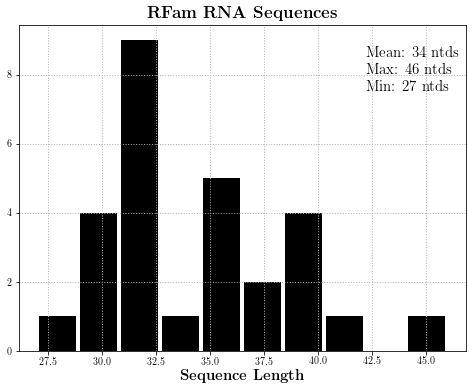

In [29]:
plt.figure(figsize = (8,6))
plt.title(r'{\bf RFam RNA Sequences}', fontsize = 17)
plt.grid(True, linestyle = ':', linewidth = 1)
plt.hist(seqLength, bins = 10, histtype = 'bar', rwidth = 0.9, color = 'black', linewidth = 2)
plt.xlabel(r'{\bf Sequence Length}', fontsize = 15)
plt.text(42.25, 8.5, r'Mean: %d ntds' %(34), fontsize = 15)
plt.text(42.25, 8, r'Max: %d ntds' %(46), fontsize = 15)
plt.text(42.25, 7.5, r'Min: %d ntds' %(27), fontsize = 15)
plt.savefig('rfam.eps', format = 'eps')
plt.show()

In [16]:
vienna_mistakes = []
for i in range(len(sequences2)-1):
    pred = RNA.fold(sequences2[i])[0]
    mist = compareStructs(pred, dotbrackets2[i])
    mist /= len(sequences2[i])
    vienna_mistakes.append(mist)   

In [17]:
print(len(vienna_mistakes))
print(np.mean(vienna_mistakes))
print(np.min(vienna_mistakes))
print(np.max(vienna_mistakes))

27
0.09897273675741847
0.0
0.5714285714285714


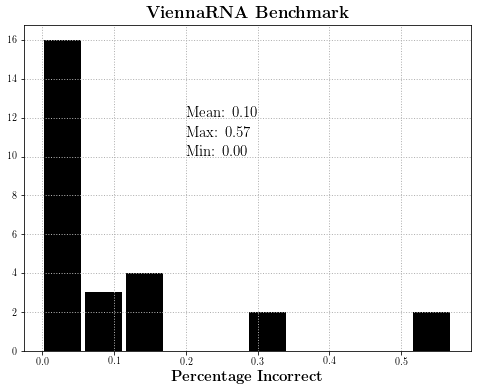

In [28]:
plt.figure(figsize = (8,6))
plt.grid(True, linestyle = ':', linewidth = 1)
plt.hist(vienna_mistakes, bins = 10, histtype = 'bar', rwidth = 0.9, color = 'black',linewidth = 2)
plt.text(0.2, 12, r'Mean: %0.2f ' %(np.mean(vienna_mistakes)), fontsize = 15)
plt.text(0.2, 11, r'Max: %0.2f ' %(np.max(vienna_mistakes)), fontsize = 15)
plt.text(0.2, 10, r'Min: %0.2f ' %(np.min(vienna_mistakes)), fontsize = 15)
plt.title(r'{\bf ViennaRNA Benchmark}', fontsize = 17)
plt.xlabel(r'{\bf Percentage Incorrect}', fontsize = 15)
plt.savefig('v_rna_bench.eps', format = 'eps')
plt.show()

In [22]:
total_misses = []
for i in range(len(sequences2)):
    G = Gillespie(sequences2[i], [], maxTime = 5, toPrint = False)
    structure = G.runGillespie()
    mistakes = compareStructs(structure, dotbrackets2[i])
    mistakes /= len(sequences2[i])
    total_misses.append(mistakes)

AttributeError: 'RNALandscape' object has no attribute 'fileTxt'

In [23]:
print(len(total_misses))
print(np.mean(total_misses))
print(np.min(total_misses))
print(np.max(total_misses))

26
0.3823918907306047
0.20689655172413793
0.5365853658536586


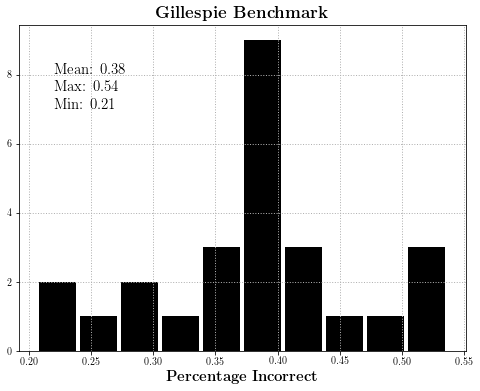

In [30]:
plt.figure(figsize = (8,6))
plt.grid(True, linestyle = ':', linewidth = 1)
plt.hist(total_misses, bins = 10, histtype = 'bar', rwidth = 0.9, color = 'black',linewidth = 2)
plt.text(0.22, 8, r'Mean: %0.2f ' %(np.mean(total_misses)), fontsize = 15)
plt.text(0.22, 7.5, r'Max: %0.2f ' %(np.max(total_misses)), fontsize = 15)
plt.text(0.22, 7, r'Min: %0.2f ' %(np.min(total_misses)), fontsize = 15)
plt.title(r'{\bf Gillespie Benchmark}', fontsize = 17)
plt.xlabel(r'{\bf Percentage Incorrect}', fontsize = 15)
plt.savefig('gill_bench.eps', format = 'eps')
plt.show()